In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from poisson_glm_granger import compute_granger_causality
from joblib import Parallel, delayed
from statsmodels.stats.multitest import multipletests
from matplotlib.gridspec import GridSpec

In [2]:
subjects=['S1','S2','S3','S5','S6','S7','S8','S10','S11','S13','S14','S15']

def load_subject_data(conditions, subjects, data_path='./Binned'):
    """
    Preload all subject data for all conditions.
    """
    all_data = {cond: [] for cond in conditions}

    for cond in conditions:
        for subject in subjects:
            c3_data = scipy.io.loadmat(f'{data_path}/c3_binned_{cond}_subject_{subject}.mat')
            c3_data = np.moveaxis(c3_data[f'c3_binned_{cond}'], [0,1,2],[0, 2, 1])
            
            f4_data = scipy.io.loadmat(f'{data_path}/f4_binned_{cond}_subject_{subject}.mat')
            f4_data = np.moveaxis(f4_data[f'f4_binned_{cond}'], [0,1,2],[0, 2, 1])

            all_data[cond].append(np.vstack([c3_data, f4_data]))

    return all_data

In [3]:
# Preload data
all_data = load_subject_data(
    conditions=['FS', 'SS', 'GO'],
    subjects=subjects,
    data_path='./Binned'
)

In [4]:
best_windows={
    'FS': [],
    'SS': [],
    'GO': []
}
gc_matrices={
    'FS': [],
    'SS': [],
    'GO': []
}
signed_gc_matrices={
    'FS': [],
    'SS': [],
    'GO': []
}

for s_idx, subject in enumerate(subjects):
    for cond in gc_matrices:
        print(f'{subject} - {cond}')
        X=all_data[cond][s_idx]

        best_window, gc_matrix, signed_gc_matrix = compute_granger_causality(
            X, 
            window_range=(1, 20), 
            folds=10,
            n_jobs=-1
        )
        best_windows[cond].append(best_window)
        gc_matrices[cond].append(gc_matrix)
        signed_gc_matrices[cond].append(signed_gc_matrix)

S1 - FS
Data contains 2 neurons, 188 trials, and 300 time steps.
Source 0 -> Target 0: Optimal window = 9, CV score = -0.0379
Source 1 -> Target 0: Optimal window = 9, CV score = -0.0380
Source 0 -> Target 1: Optimal window = 8, CV score = -0.0367
Source 1 -> Target 1: Optimal window = 8, CV score = -0.0367
S1 - SS
Data contains 2 neurons, 172 trials, and 300 time steps.
Source 0 -> Target 0: Optimal window = 18, CV score = -0.0384
Source 1 -> Target 0: Optimal window = 18, CV score = -0.0385
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0349
Source 1 -> Target 1: Optimal window = 20, CV score = -0.0348
S1 - GO
Data contains 2 neurons, 1042 trials, and 300 time steps.
Source 0 -> Target 0: Optimal window = 20, CV score = -0.0389
Source 1 -> Target 0: Optimal window = 20, CV score = -0.0389
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0343
Source 1 -> Target 1: Optimal window = 20, CV score = -0.0342
S2 - FS
Data contains 2 neurons, 158 trials, and 300 time steps.

Source 0 -> Target 0: Optimal window = 20, CV score = -0.0249
Source 1 -> Target 0: Optimal window = 20, CV score = -0.0249
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0370
Source 1 -> Target 1: Optimal window = 20, CV score = -0.0370
S13 - FS
Data contains 2 neurons, 157 trials, and 300 time steps.
Source 0 -> Target 0: Optimal window = 20, CV score = -0.0328
Source 1 -> Target 0: Optimal window = 16, CV score = -0.0330
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0354
Source 1 -> Target 1: Optimal window = 20, CV score = -0.0353
S13 - SS
Data contains 2 neurons, 150 trials, and 300 time steps.
Source 0 -> Target 0: Optimal window = 20, CV score = -0.0322
Source 1 -> Target 0: Optimal window = 20, CV score = -0.0323
Source 0 -> Target 1: Optimal window = 19, CV score = -0.0358
Source 1 -> Target 1: Optimal window = 20, CV score = -0.0358
S13 - GO
Data contains 2 neurons, 1069 trials, and 300 time steps.
Source 0 -> Target 0: Optimal window = 20, CV score = -0.

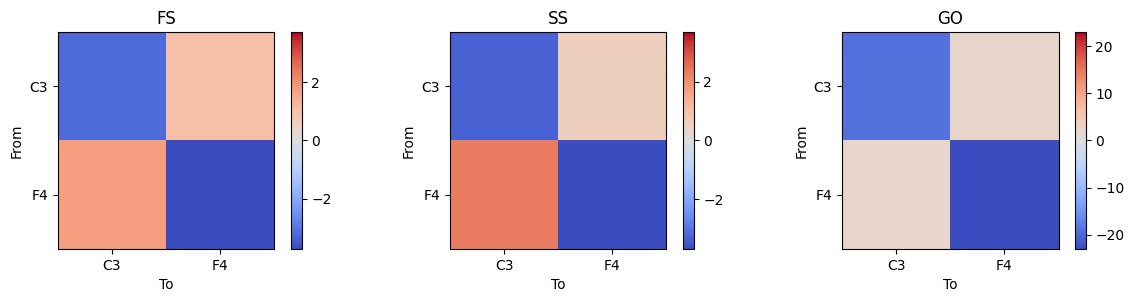

In [5]:
fig=plt.figure(figsize=(12,3))
gs = GridSpec(1, 3)
for cond_idx, cond in enumerate(signed_gc_matrices):
    ax = fig.add_subplot(gs[0,cond_idx])
    gc_mat=np.mean(np.array(signed_gc_matrices[cond]),axis=0)
    maxabs=np.max(np.abs(gc_mat[:]))
    # Display results
    im=plt.imshow(gc_mat, cmap='coolwarm', interpolation='none', clim=[-maxabs, maxabs])
    plt.colorbar()
    plt.title(cond)
    plt.xlabel("To")
    plt.ylabel("From")
    plt.xticks([0,1])
    ax.set_xticklabels(['C3','F4'])
    plt.yticks([0,1])
    ax.set_yticklabels(['C3','F4'])
plt.tight_layout()

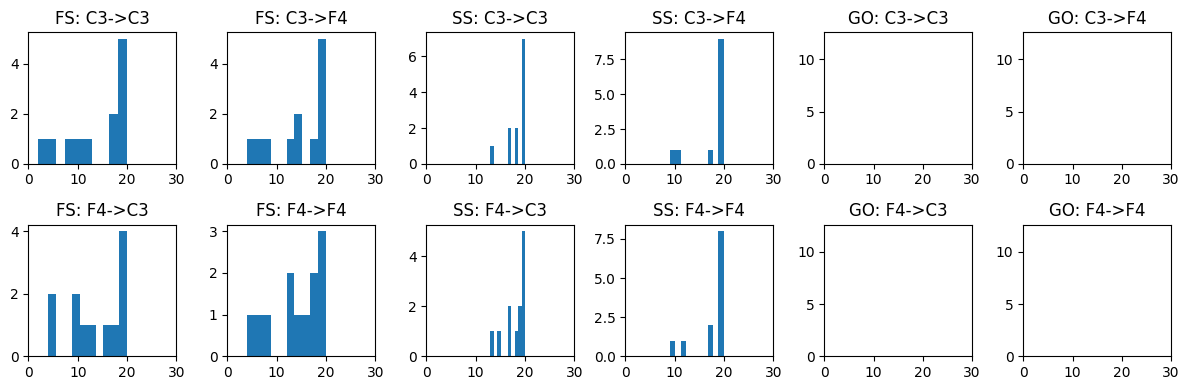

In [6]:
labels=['C3','F4']
fig=plt.figure(figsize=(12,4)) 
gs = GridSpec(2, 6)
for cond_idx, cond in enumerate(signed_gc_matrices):
    for source in range(2):
        for target in range(2):
            ax = fig.add_subplot(gs[source,cond_idx*2+target])
            plt.hist([x[(source,target)][0] for x in best_windows[cond]])
            plt.xlim([0,30])
            plt.title(f'{cond}: {labels[source]}->{labels[target]}')
plt.tight_layout()

In [7]:
def shuffle_trials(data):
    """
    Shuffle trials for all neurons in the data array.

    Parameters:
    ----------
    data : ndarray
        The input data array of shape (neurons, trials, time_steps).

    Returns:
    -------
    ndarray
        A shuffled version of the input data with shuffled trials.
    """
    shuffled_data = data.copy()
    neurons, trials, _ = shuffled_data.shape

    for neuron in range(neurons):
        shuffled_data[neuron, :, :] = shuffled_data[neuron, np.random.permutation(trials), :]
    return shuffled_data


def shuffle_time(data):
    """
    Shuffle time points for all neurons in the data array.

    Parameters:
    ----------
    data : ndarray
        The input data array of shape (neurons, trials, time_steps).

    Returns:
    -------
    ndarray
        A shuffled version of the input data with shuffled time points.
    """
    shuffled_data = data.copy()
    neurons, _, time_steps = shuffled_data.shape

    for neuron in range(neurons):
        for trial in range(shuffled_data.shape[1]):
            shuffled_data[neuron, trial, :] = np.random.permutation(shuffled_data[neuron, trial, :])
    return shuffled_data


# Permutation test with separate shuffling for trials and time
conditions = ['FS', 'SS', 'GO']
n_permutations = 1000
alpha = 0.05

neurons = gc_matrices[conditions[0]][0].shape[0]
permuted_gc_matrices = {cond: [] for cond in conditions}
permuted_signed_gc_matrices = {cond: [] for cond in conditions}

# Run permutations one at a time to avoid large memory usage
for perm_idx in range(n_permutations):
    for cond in conditions:
        permuted_gc_matrix = np.zeros((neurons, neurons))
        permuted_signed_gc_matrix = np.zeros((neurons, neurons))
        
        for s_idx, subject_data in enumerate(all_data[cond]):
            print(f'Permutation {perm_idx}, Condition {cond}, Subject {s_idx}')

            # Shuffle trials for off-diagonal elements
            shuffled_trials_X = shuffle_trials(subject_data)
            _, gc_trials, signed_gc_trials = compute_granger_causality(
                shuffled_trials_X,
                n_jobs=-1,
                pairwise_windows=best_windows[cond][s_idx]
            )

            # Shuffle time for diagonal elements
            shuffled_time_X = shuffle_time(subject_data)
            _, gc_time, signed_gc_time = compute_granger_causality(
                shuffled_time_X,
                n_jobs=-1,
                pairwise_windows=best_windows[cond][s_idx]
            )

            # Combine results: diagonal from time shuffling, off-diagonal from trial shuffling
            for i in range(neurons):
                for j in range(neurons):
                    if i == j:
                        permuted_gc_matrix[i, j] += gc_time[i, j]
                        permuted_signed_gc_matrix[i, j] += signed_gc_time[i, j]
                    else:
                        permuted_gc_matrix[i, j] += gc_trials[i, j]
                        permuted_signed_gc_matrix[i, j] += signed_gc_trials[i, j]

        # Average across subjects
        permuted_gc_matrices[cond].append(permuted_gc_matrix / len(subjects))
        permuted_signed_gc_matrices[cond].append(permuted_signed_gc_matrix / len(subjects))


Permutation 0, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 0, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 0, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 0, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 0, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 0, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 0, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 30

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 1, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 1, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 1, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 1, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 1, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 1, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 1, Conditio

Permutation 2, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 3, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 3, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 3, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 3, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 3, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 3, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 4, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 4, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 4, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 4, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 4, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 4, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 4, Condition

Permutation 5, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 5, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 6, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 6, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 6, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 6, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 6, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 7, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 7, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 7, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 7, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 7, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 7, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 7, Condition 

Permutation 8, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 8, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 8, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 9, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 9, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 9, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 9, Condition FS, Subject 3
Data contains 2 neurons, 194 trials

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 10, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 10, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 10, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 10, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 10, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 10, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 10, Con

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 11, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 11, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 11, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 11, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 12, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 12, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutatio

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 13, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 13, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 13, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 13, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 13, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 13, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 13, Con

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 14, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 14, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 14, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 14, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 14, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 14, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 16, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 16, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 16, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 16, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 16, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 16, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 16, Co

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 17, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 17, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 17, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 17, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 17, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 17, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutatio

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 19, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 19, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 19, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 19, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 19, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 19, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 19, C

Permutation 20, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 20, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 20, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 20, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 20, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 20, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 20, Condition GO, Subject 8
Data contains 2 neurons, 9

Permutation 22, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 22, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 22, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 22, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 22, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 22, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 22, Condition SS, Subject 1
Data contains 2 neurons, 154 trial

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 23, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 23, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 23, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 23, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 23, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 23, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutatio

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 25, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 25, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 25, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 25, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 25, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 25, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 25, C

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 26, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 26, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 26, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 26, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 26, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 26, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 28, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 28, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 28, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 28, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 28, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 28, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 28, Co

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 29, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 29, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 29, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 29, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 29, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 29, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutatio

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 31, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 31, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 31, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 31, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 31, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 31, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 31, Con

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 32, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 32, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 32, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 32, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 32, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 32, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 34, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 34, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 34, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 34, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 34, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 34, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 34, Con

Permutation 35, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 35, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 35, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 35, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 35, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 35, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 35, Condition GO, Subject 2
Data contains 2 neurons, 1116 tr

Permutation 37, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 37, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 37, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 37, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 37, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 37, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 37, Condition FS, Subject 7
Data contains 2 neurons, 171 trials,

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 38, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 38, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 38, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 38, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 38, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 38, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 38,

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 40, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 40, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 40, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 40, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 40, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 40, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 40, Co

Permutation 41, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 41, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 41, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 41, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 41, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 41, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 41, Condition SS, Subject 11
Data contains 2 neurons, 154 trial

Permutation 42, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 42, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 43, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 43, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 43, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 43, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 43, Condition FS, Subject 4
Data contains 2 neurons, 181 t

Permutation 44, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 44, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 44, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 44, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 44, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 44, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 44, Condition SS, Subject 9
Data contains 2 neurons, 150 trials,

Permutation 45, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 45, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 45, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 45, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 46, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 46, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 46, Condition FS, Subject 2
Data contains 2 neurons, 198

Permutation 47, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 47, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 47, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 47, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 47, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 47, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 47, Condition SS, Subject 7
Data contains 2 neurons, 156 trials,

Permutation 48, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 48, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 48, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 48, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 48, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 48, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 49, Condition FS, Subject 0
Data contains 2 neurons,

Permutation 50, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 50, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 50, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 50, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 50, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 50, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 50, Condition SS, Subject 5
Data contains 2 neurons, 154 trials

Permutation 51, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 51, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 51, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 51, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 51, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 51, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 51, Condition GO, Subject 10
Data contains 2 neurons, 10

Permutation 53, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 53, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 53, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 53, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 53, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 53, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 53, Condition SS, Subject 3
Data contains 2 neurons, 195 trial

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 54, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 54, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 54, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 54, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 54, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 54, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutatio

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 56, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 56, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 56, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 56, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 56, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 56, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 56, C

Permutation 57, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 57, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 57, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 57, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 57, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 57, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 57, Condition GO, Subject 7
Data contains 2 neurons, 117

Permutation 59, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 59, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 59, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 59, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 59, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 59, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 59, Condition SS, Subject 0
Data contains 2 neurons, 172 trial

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 60, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 60, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 60, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 60, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 60, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 60, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 62, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 62, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 62, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 62, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 62, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 62, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 62, Co

Permutation 63, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 63, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 63, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 63, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 63, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 63, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 63, Condition GO, Subject 4
Data contains 2 neurons, 108

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 65, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 65, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 65, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 65, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 65, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 65, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 65, Con

Permutation 66, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 66, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 66, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 66, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 66, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 66, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 66, Condition GO, Subject 3
Data contains 2 neurons, 1139 

Permutation 68, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 68, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 68, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 68, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 68, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 68, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 68, Condition FS, Subject 8
Data contains 2 neurons, 130 trials,

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 69, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 69, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 69, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 69, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 69, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 69, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 69,

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 71, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 71, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 71, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 71, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 71, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 71, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 71, Con

Permutation 72, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 72, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 72, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 72, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 72, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 72, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 72, Condition GO, Subject 0
Data contains 2 neurons, 1042 tria

Permutation 73, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 74, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 74, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 74, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 74, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 74, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 74, Condition FS, Subject 5
Data contains 2 neurons, 145 tria

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 75, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 75, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 75, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 75, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 75, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 75, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 75, Co

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 76, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 76, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 77, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 77, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 77, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 77, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 78, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 78, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 78, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 78, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 78, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 78, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 78, Con

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 79, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 79, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 79, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 79, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 80, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 80, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutatio

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 81, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 81, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 81, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 81, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 81, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 81, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 81, Con

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 82, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 82, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 82, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 82, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 82, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 82, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 84, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 84, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 84, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 84, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 84, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 84, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 84, Co

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 85, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 85, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 85, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 85, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 85, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 85, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutatio

Permutation 87, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 87, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 87, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 87, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 87, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 87, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 87, Condition SS, Subject 3
Data contains 2 neurons, 195 trial

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 88, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 88, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 88, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 88, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 88, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 88, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutatio

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 90, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 90, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 90, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 90, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 90, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 90, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 90, C

Permutation 91, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 91, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 91, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 91, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 91, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 91, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 91, Condition GO, Subject 7
Data contains 2 neurons, 117

Permutation 93, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 93, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 93, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 93, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 93, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 93, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 93, Condition SS, Subject 0
Data contains 2 neurons, 172 trial

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 94, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 94, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 94, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 94, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 94, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 94, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 96, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 96, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 96, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 96, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 96, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 96, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 96, Co

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 97, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 97, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 97, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 97, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 97, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 97, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutatio

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 99, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 99, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 99, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 99, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 99, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 99, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 99, Con

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 100, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 100, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 100, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 100, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 100, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 100, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 102, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 102, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 102, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 102, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 102, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 102, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 103, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 103, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 103, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 103, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 103, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 103, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 105, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 105, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 105, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 105, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 105, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 105, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 106, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 106, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 106, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 106, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 106, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 106, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 107, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 107, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 108, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 108, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 108, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 108, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 109, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 109, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 109, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 109, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 109, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 109, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 110, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 110, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 110, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 110, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 111, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 111, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 112, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 112, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 112, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 112, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 112, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 112, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 113, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 113, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 113, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 113, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 113, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 113, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 115, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 115, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 115, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 115, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 115, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 115, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 116, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 116, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 116, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 116, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 116, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 116, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 118, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 118, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 118, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 118, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 118, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 118, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 119, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 119, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 119, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 119, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 119, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 119, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 121, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 121, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 121, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 121, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 121, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 121, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 122, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 122, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 122, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 122, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 122, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 122, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 124, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 124, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 124, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 124, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 124, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 124, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 125, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 125, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 125, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 125, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 125, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 125, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 127, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 127, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 127, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 127, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 127, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 127, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 128, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 128, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 128, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 128, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 128, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 128, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 130, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 130, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 130, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 130, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 130, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 130, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 131, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 131, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 131, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 131, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 131, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 131, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 132, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 133, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 133, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 133, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 133, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 133, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 134, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 134, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 134, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 134, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 134, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 134, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 135, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 135, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 135, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 136, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 136, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 136, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 137, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 137, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 137, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 137, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 137, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 137, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 138, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 138, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 138, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 138, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 138, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 139, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 140, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 140, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 140, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 140, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 140, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 140, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 141, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 141, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 141, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 141, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 141, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 141, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 143, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 143, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 143, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 143, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 143, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 143, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 144, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 144, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 144, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 144, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 144, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 144, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 146, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 146, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 146, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 146, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 146, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 146, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 147, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 147, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 147, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 147, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 147, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 147, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 149, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 149, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 149, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 149, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 149, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 149, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 150, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 150, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 150, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 150, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 150, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 150, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 152, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 152, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 152, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 152, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 152, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 152, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 153, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 153, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 153, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 153, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 153, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 153, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 155, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 155, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 155, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 155, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 155, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 155, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 156, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 156, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 156, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 156, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 156, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 156, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 158, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 158, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 158, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 158, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 158, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 158, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 159, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 159, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 159, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 159, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 159, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 159, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 160, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 160, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 161, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 161, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 161, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 161, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 162, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 162, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 162, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 162, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 162, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 162, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 163, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 163, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 163, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 163, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 164, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 164, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 165, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 165, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 165, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 165, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 165, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 165, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 166, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 166, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 166, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 166, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 166, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 166, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 168, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 168, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 168, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 168, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 168, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 168, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 169, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 169, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 169, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 169, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 169, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 169, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Permutation 171, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 171, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 171, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 171, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 171, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 171, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 171, Condition SS, Subject 3
Data contains 2 neurons, 19

Permutation 172, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 172, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 172, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 172, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 172, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 172, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 172, Condition GO, Subject 8
Data contains 2 neu

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 174, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 174, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 174, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 174, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 174, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 174, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 175, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 175, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 175, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 175, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 175, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 175, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 177, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 177, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 177, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 177, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 177, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 177, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 178, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 178, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 178, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 178, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 178, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 178, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 180, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 180, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 180, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 180, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 180, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 180, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 181, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 181, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 181, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 181, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 181, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 181, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 183, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 183, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 183, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 183, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 183, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 183, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 184, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 184, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 184, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 184, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 184, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 184, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 185, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 186, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 186, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 186, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 186, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 186, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 187, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 187, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 187, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 187, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 187, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 187, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 188, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 188, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 188, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 189, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 189, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 189, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 190, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 190, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 190, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 190, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 190, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 190, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 191, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 191, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 191, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 191, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 191, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 192, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 193, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 193, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 193, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 193, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 193, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 193, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 1

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 194, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 194, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 194, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 194, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 194, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 194, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 196, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 196, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 196, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 196, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 196, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 196, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 197, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 197, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 197, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 197, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 197, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 197, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 199, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 199, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 199, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 199, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 199, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 199, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 200, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 200, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 200, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 200, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 200, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 200, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 202, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 202, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 202, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 202, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 202, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 202, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 203, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 203, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 203, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 203, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 203, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 203, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 205, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 205, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 205, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 205, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 205, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 205, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 206, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 206, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 206, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 206, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 206, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 206, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 208, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 208, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 208, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 208, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 208, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 208, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 209, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 209, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 209, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 209, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 209, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 209, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 211, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 211, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 211, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 211, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 211, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 211, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 212, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 212, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 212, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 212, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 212, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 212, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 213, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 213, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 214, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 214, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 214, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 214, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 215, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 215, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 215, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 215, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 215, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 215, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 216, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 216, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 216, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 216, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 217, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 217, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 218, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 218, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 218, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 218, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 218, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 218, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 219, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 219, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 219, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 219, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 219, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 219, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 221, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 221, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 221, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 221, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 221, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 221, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 222, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 222, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 222, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 222, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 222, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 222, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 224, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 224, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 224, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 224, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 224, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 224, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 225, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 225, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 225, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 225, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 225, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 225, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 227, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 227, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 227, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 227, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 227, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 227, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 228, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 228, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 228, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 228, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 228, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 228, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 230, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 230, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 230, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 230, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 230, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 230, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 231, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 231, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 231, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 231, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 231, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 231, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 233, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 233, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 233, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 233, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 233, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 233, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 234, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 234, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 234, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 234, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 234, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 234, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 236, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 236, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 236, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 236, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 236, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 236, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 237, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 237, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 237, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 237, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 237, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 237, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 238, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 239, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 239, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 239, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 239, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 239, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 240, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 240, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 240, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 240, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 240, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 240, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 241, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 241, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 241, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 242, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 242, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 242, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 243, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 243, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 243, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 243, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 243, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 243, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 244, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 244, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 244, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 244, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 244, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 245, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 246, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 246, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 246, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 246, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 246, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 246, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 247, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 247, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 247, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 247, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 247, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 247, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 249, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 249, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 249, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 249, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 249, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 249, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 250, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 250, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 250, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 250, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 250, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 250, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 252, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 252, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 252, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 252, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 252, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 252, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 253, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 253, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 253, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 253, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 253, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 253, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 255, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 255, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 255, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 255, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 255, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 255, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 256, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 256, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 256, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 256, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 256, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 256, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 258, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 258, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 258, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 258, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 258, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 258, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 259, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 259, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 259, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 259, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 259, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 259, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 261, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 261, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 261, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 261, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 261, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 261, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 262, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 262, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 262, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 262, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 262, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 262, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 264, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 264, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 264, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 264, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 264, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 264, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 265, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 265, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 265, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 265, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 265, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 265, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 266, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 266, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 267, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 267, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 267, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 267, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 268, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 268, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 268, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 268, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 268, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 268, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 269, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 269, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 269, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 269, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 270, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 270, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 271, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 271, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 271, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 271, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 271, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 271, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 272, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 272, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 272, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 272, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 272, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 272, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 274, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 274, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 274, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 274, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 274, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 274, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 275, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 275, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 275, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 275, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 275, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 275, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 277, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 277, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 277, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 277, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 277, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 277, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 278, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 278, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 278, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 278, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 278, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 278, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 280, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 280, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 280, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 280, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 280, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 280, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 281, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 281, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 281, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 281, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 281, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 281, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 283, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 283, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 283, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 283, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 283, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 283, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 284, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 284, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 284, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 284, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 284, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 284, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 286, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 286, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 286, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 286, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 286, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 286, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 287, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 287, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 287, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 287, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 287, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 287, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 289, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 289, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 289, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 289, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 289, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 289, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 290, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 290, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 290, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 290, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 290, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 290, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 291, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 292, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 292, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 292, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 292, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 292, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 293, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 293, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 293, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 293, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 293, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 293, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 294, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 294, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 294, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 295, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 295, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 295, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 296, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 296, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 296, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 296, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 296, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 296, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 297, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 297, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 297, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 297, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 297, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 298, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 299, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 299, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 299, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 299, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 299, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 299, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 2

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 300, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 300, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 300, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 300, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 300, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 300, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 302, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 302, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 302, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 302, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 302, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 302, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 303, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 303, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 303, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 303, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 303, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 303, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 305, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 305, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 305, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 305, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 305, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 305, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 306, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 306, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 306, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 306, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 306, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 306, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 308, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 308, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 308, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 308, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 308, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 308, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 309, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 309, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 309, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 309, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 309, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 309, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 311, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 311, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 311, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 311, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 311, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 311, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 312, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 312, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 312, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 312, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 312, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 312, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 314, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 314, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 314, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 314, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 314, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 314, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 315, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 315, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 315, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 315, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 315, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 315, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 317, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 317, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 317, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 317, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 317, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 317, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 318, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 318, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 318, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 318, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 318, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 318, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 319, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 319, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 320, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 320, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 320, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 320, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 321, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 321, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 321, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 321, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 321, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 321, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 322, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 322, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 322, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 322, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 323, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 323, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 324, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 324, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 324, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 324, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 324, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 324, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 325, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 325, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 325, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 325, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 325, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 325, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Permutation 327, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 327, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 327, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 327, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 327, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 327, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 327, Condition SS, Subject 5
Data contains 2 neurons, 154

Permutation 328, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 328, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 328, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 328, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 328, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 328, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 328, Condition GO, Subject 10
Data contains 2 neur

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 330, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 330, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 330, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 330, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 330, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 330, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 331, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 331, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 331, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 331, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 331, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 331, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 333, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 333, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 333, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 333, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 333, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 333, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 334, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 334, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 334, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 334, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 334, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 334, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 336, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 336, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 336, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 336, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 336, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 336, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 337, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 337, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 337, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 337, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 337, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 337, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 339, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 339, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 339, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 339, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 339, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 339, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 340, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 340, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 340, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 340, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 340, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 340, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 342, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 342, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 342, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 342, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 342, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 342, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 343, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 343, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 343, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 343, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 343, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 343, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 344, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 345, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 345, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 345, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 345, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 345, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 346, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 346, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 346, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 346, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 346, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 346, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 347, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 347, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 347, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 348, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 348, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 348, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 349, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 349, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 349, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 349, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 349, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 349, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 350, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 350, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 350, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 350, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 350, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 351, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 352, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 352, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 352, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 352, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 352, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 352, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 353, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 353, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 353, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 353, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 353, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 353, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 355, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 355, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 355, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 355, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 355, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 355, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 356, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 356, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 356, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 356, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 356, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 356, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 358, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 358, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 358, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 358, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 358, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 358, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 359, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 359, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 359, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 359, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 359, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 359, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 361, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 361, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 361, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 361, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 361, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 361, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 362, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 362, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 362, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 362, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 362, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 362, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 364, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 364, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 364, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 364, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 364, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 364, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 365, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 365, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 365, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 365, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 365, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 365, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 367, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 367, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 367, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 367, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 367, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 367, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 368, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 368, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 368, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 368, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 368, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 368, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 370, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 370, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 370, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 370, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 370, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 370, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 371, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 371, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 371, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 371, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 371, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 371, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 372, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 372, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 373, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 373, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 373, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 373, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 374, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 374, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 374, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 374, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 374, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 374, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 375, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 375, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 375, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 375, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 376, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 376, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 377, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 377, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 377, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 377, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 377, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 377, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 378, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 378, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 378, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 378, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 378, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 378, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 380, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 380, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 380, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 380, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 380, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 380, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 381, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 381, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 381, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 381, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 381, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 381, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 383, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 383, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 383, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 383, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 383, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 383, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 384, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 384, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 384, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 384, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 384, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 384, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 386, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 386, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 386, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 386, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 386, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 386, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 387, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 387, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 387, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 387, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 387, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 387, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 389, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 389, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 389, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 389, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 389, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 389, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 390, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 390, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 390, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 390, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 390, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 390, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 392, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 392, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 392, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 392, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 392, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 392, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 393, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 393, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 393, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 393, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 393, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 393, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 395, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 395, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 395, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 395, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 395, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 395, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 396, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 396, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 396, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 396, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 396, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 396, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 397, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 398, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 398, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 398, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 398, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 398, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 399, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 399, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 399, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 399, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 399, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 399, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 3

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 400, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 400, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 400, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 401, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 401, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 401, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 402, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 402, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 402, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 402, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 402, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 402, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 403, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 403, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 403, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 403, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 403, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 404, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 405, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 405, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 405, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 405, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 405, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 405, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 406, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 406, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 406, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 406, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 406, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 406, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 408, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 408, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 408, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 408, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 408, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 408, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 409, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 409, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 409, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 409, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 409, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 409, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 411, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 411, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 411, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 411, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 411, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 411, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 412, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 412, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 412, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 412, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 412, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 412, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 414, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 414, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 414, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 414, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 414, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 414, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 415, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 415, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 415, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 415, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 415, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 415, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 417, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 417, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 417, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 417, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 417, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 417, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 418, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 418, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 418, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 418, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 418, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 418, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 420, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 420, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 420, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 420, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 420, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 420, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 421, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 421, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 421, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 421, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 421, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 421, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 423, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 423, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 423, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 423, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 423, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 423, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 424, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 424, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 424, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 424, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 424, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 424, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 425, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 425, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 426, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 426, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 426, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 426, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 427, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 427, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 427, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 427, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 427, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 427, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 428, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 428, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 428, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 428, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 429, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 429, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 430, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 430, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 430, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 430, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 430, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 430, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 431, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 431, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 431, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 431, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 431, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 431, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Permutation 433, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 433, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 433, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 433, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 433, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 433, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 433, Condition SS, Subject 5
Data contains 2 neurons, 154

Permutation 434, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 434, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 434, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 434, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 434, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 434, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 434, Condition GO, Subject 10
Data contains 2 neur

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 436, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 436, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 436, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 436, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 436, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 436, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 437, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 437, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 437, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 437, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 437, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 437, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 439, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 439, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 439, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 439, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 439, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 439, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 440, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 440, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 440, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 440, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 440, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 440, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 442, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 442, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 442, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 442, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 442, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 442, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 443, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 443, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 443, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 443, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 443, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 443, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 445, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 445, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 445, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 445, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 445, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 445, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 446, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 446, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 446, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 446, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 446, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 446, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 448, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 448, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 448, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 448, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 448, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 448, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 449, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 449, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 449, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 449, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 449, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 449, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 450, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 451, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 451, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 451, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 451, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 451, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 452, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 452, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 452, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 452, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 452, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 452, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 453, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 453, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 453, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 454, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 454, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 454, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 455, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 455, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 455, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 455, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 455, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 455, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 456, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 456, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 456, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 456, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 456, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 457, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 458, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 458, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 458, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 458, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 458, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 458, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 459, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 459, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 459, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 459, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 459, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 459, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 461, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 461, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 461, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 461, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 461, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 461, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 462, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 462, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 462, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 462, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 462, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 462, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 464, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 464, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 464, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 464, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 464, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 464, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 465, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 465, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 465, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 465, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 465, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 465, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 467, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 467, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 467, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 467, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 467, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 467, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 468, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 468, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 468, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 468, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 468, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 468, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 470, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 470, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 470, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 470, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 470, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 470, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 471, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 471, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 471, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 471, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 471, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 471, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 473, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 473, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 473, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 473, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 473, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 473, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 474, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 474, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 474, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 474, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 474, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 474, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 476, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 476, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 476, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 476, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 476, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 476, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 477, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 477, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 477, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 477, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 477, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 477, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 478, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 478, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 479, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 479, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 479, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 479, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 480, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 480, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 480, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 480, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 480, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 480, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 481, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 481, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 481, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 481, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 482, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 482, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 483, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 483, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 483, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 483, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 483, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 483, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 484, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 484, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 484, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 484, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 484, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 484, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 486, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 486, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 486, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 486, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 486, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 486, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 487, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 487, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 487, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 487, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 487, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 487, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 489, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 489, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 489, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 489, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 489, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 489, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 490, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 490, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 490, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 490, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 490, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 490, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 492, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 492, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 492, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 492, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 492, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 492, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 493, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 493, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 493, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 493, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 493, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 493, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 495, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 495, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 495, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 495, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 495, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 495, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 496, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 496, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 496, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 496, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 496, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 496, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 498, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 498, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 498, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 498, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 498, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 498, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 4

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 499, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 499, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 499, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 499, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 499, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 499, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 501, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 501, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 501, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 501, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 501, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 501, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 502, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 502, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 502, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 502, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 502, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 502, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 503, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 504, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 504, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 504, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 504, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 504, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 505, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 505, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 505, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 505, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 505, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 505, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 506, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 506, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 506, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 507, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 507, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 507, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 508, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 508, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 508, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 508, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 508, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 508, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 509, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 509, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 509, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 509, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 509, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 510, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 511, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 511, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 511, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 511, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 511, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 511, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 512, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 512, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 512, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 512, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 512, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 512, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 514, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 514, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 514, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 514, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 514, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 514, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 515, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 515, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 515, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 515, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 515, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 515, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 517, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 517, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 517, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 517, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 517, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 517, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 518, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 518, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 518, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 518, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 518, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 518, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 520, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 520, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 520, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 520, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 520, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 520, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 521, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 521, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 521, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 521, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 521, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 521, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 523, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 523, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 523, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 523, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 523, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 523, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 524, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 524, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 524, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 524, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 524, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 524, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 526, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 526, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 526, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 526, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 526, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 526, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 527, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 527, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 527, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 527, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 527, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 527, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 529, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 529, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 529, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 529, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 529, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 529, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 530, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 530, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 530, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 530, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 530, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 530, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 531, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 531, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 532, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 532, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 532, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 532, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 533, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 533, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 533, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 533, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 533, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 533, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 534, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 534, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 534, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 534, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 535, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 535, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 536, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 536, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 536, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 536, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 536, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 536, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 537, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 537, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 537, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 537, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 537, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 537, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 539, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 539, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 539, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 539, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 539, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 539, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 540, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 540, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 540, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 540, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 540, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 540, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Permutation 542, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 542, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 542, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 542, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 542, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 542, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 542, Condition SS, Subject 3
Data contains 2 neurons, 19

Permutation 543, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 543, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 543, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 543, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 543, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 543, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 543, Condition GO, Subject 8
Data contains 2 neu

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 545, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 545, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 545, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 545, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 545, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 545, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 546, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 546, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 546, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 546, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 546, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 546, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 548, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 548, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 548, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 548, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 548, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 548, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 549, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 549, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 549, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 549, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 549, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 549, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 551, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 551, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 551, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 551, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 551, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 551, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 552, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 552, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 552, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 552, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 552, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 552, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 554, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 554, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 554, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 554, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 554, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 554, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 555, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 555, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 555, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 555, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 555, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 555, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 556, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 557, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 557, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 557, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 557, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 557, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 558, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 558, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 558, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 558, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 558, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 558, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 559, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 559, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 559, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 560, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 560, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 560, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 561, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 561, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 561, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 561, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 561, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 561, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 562, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 562, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 562, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 562, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 562, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 563, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 564, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 564, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 564, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 564, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 564, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 564, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 565, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 565, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 565, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 565, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 565, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 565, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 567, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 567, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 567, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 567, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 567, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 567, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 568, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 568, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 568, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 568, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 568, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 568, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 570, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 570, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 570, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 570, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 570, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 570, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 571, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 571, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 571, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 571, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 571, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 571, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 573, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 573, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 573, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 573, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 573, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 573, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 574, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 574, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 574, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 574, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 574, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 574, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 576, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 576, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 576, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 576, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 576, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 576, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 577, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 577, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 577, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 577, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 577, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 577, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 579, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 579, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 579, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 579, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 579, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 579, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 580, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 580, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 580, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 580, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 580, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 580, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 582, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 582, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 582, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 582, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 582, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 582, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 583, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 583, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 583, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 583, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 583, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 583, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 584, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 584, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 585, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 585, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 585, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 585, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 586, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 586, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 586, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 586, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 586, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 586, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 587, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 587, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 587, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 587, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 588, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 588, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 589, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 589, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 589, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 589, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 589, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 589, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 5

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 590, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 590, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 590, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 590, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 590, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 590, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 592, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 592, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 592, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 592, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 592, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 592, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 593, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 593, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 593, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 593, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 593, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 593, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 595, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 595, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 595, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 595, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 595, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 595, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 596, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 596, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 596, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 596, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 596, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 596, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 598, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 598, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 598, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 598, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 598, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 598, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 599, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 599, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 599, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 599, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 599, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 599, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 601, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 601, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 601, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 601, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 601, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 601, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 602, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 602, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 602, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 602, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 602, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 602, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 604, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 604, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 604, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 604, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 604, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 604, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 605, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 605, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 605, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 605, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 605, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 605, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 607, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 607, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 607, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 607, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 607, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 607, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 608, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 608, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 608, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 608, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 608, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 608, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 609, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 610, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 610, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 610, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 610, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 610, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 611, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 611, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 611, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 611, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 611, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 611, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 612, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 612, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 612, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 613, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 613, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 613, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 614, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 614, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 614, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 614, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 614, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 614, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 615, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 615, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 615, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 615, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 615, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 616, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 617, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 617, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 617, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 617, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 617, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 617, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 618, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 618, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 618, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 618, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 618, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 618, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 620, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 620, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 620, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 620, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 620, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 620, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 621, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 621, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 621, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 621, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 621, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 621, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 623, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 623, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 623, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 623, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 623, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 623, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 624, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 624, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 624, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 624, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 624, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 624, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 626, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 626, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 626, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 626, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 626, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 626, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 627, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 627, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 627, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 627, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 627, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 627, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 629, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 629, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 629, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 629, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 629, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 629, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 630, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 630, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 630, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 630, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 630, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 630, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 632, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 632, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 632, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 632, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 632, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 632, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 633, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 633, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 633, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 633, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 633, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 633, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 635, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 635, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 635, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 635, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 635, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 635, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 636, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 636, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 636, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 636, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 636, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 636, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 637, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 637, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 638, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 638, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 638, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 638, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 639, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 639, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 639, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 639, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 639, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 639, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 640, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 640, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 640, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 640, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 641, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 641, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 642, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 642, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 642, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 642, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 642, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 642, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 643, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 643, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 643, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 643, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 643, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 643, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 645, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 645, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 645, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 645, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 645, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 645, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 646, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 646, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 646, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 646, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 646, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 646, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 648, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 648, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 648, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 648, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 648, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 648, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 649, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 649, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 649, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 649, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 649, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 649, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 651, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 651, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 651, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 651, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 651, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 651, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 652, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 652, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 652, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 652, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 652, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 652, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 654, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 654, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 654, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 654, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 654, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 654, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 655, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 655, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 655, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 655, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 655, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 655, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 657, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 657, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 657, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 657, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 657, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 657, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 658, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 658, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 658, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 658, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 658, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 658, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 660, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 660, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 660, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 660, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 660, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 660, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 661, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 661, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 661, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 661, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 661, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 661, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 662, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 663, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 663, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 663, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 663, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 663, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 664, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 664, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 664, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 664, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 664, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 664, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 665, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 665, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 665, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 666, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 666, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 666, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 667, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 667, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 667, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 667, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 667, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 667, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 668, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 668, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 668, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 668, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 668, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 669, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 670, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 670, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 670, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 670, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 670, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 670, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 671, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 671, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 671, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 671, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 671, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 671, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 673, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 673, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 673, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 673, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 673, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 673, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 674, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 674, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 674, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 674, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 674, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 674, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 676, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 676, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 676, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 676, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 676, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 676, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 677, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 677, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 677, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 677, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 677, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 677, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 679, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 679, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 679, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 679, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 679, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 679, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 680, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 680, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 680, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 680, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 680, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 680, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 682, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 682, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 682, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 682, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 682, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 682, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 683, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 683, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 683, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 683, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 683, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 683, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 685, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 685, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 685, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 685, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 685, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 685, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 686, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 686, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 686, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 686, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 686, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 686, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 688, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 688, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 688, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 688, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 688, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 688, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 689, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 689, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 689, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 689, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 689, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 689, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 690, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 690, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 691, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 691, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 691, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 691, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 692, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 692, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 692, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 692, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 692, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 692, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 693, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 693, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 693, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 693, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 694, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 694, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 695, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 695, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 695, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 695, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 695, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 695, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 6

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 696, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 696, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 696, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 696, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 696, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 696, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Permutation 698, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 698, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 698, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 698, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 698, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 698, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 698, Condition SS, Subject 5
Data contains 2 neurons, 154

Permutation 699, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 699, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 699, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 699, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 699, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 699, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 699, Condition GO, Subject 10
Data contains 2 neur

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 701, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 701, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 701, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 701, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 701, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 701, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 702, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 702, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 702, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 702, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 702, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 702, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 704, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 704, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 704, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 704, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 704, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 704, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 705, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 705, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 705, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 705, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 705, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 705, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 707, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 707, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 707, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 707, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 707, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 707, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 708, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 708, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 708, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 708, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 708, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 708, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 710, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 710, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 710, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 710, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 710, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 710, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 711, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 711, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 711, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 711, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 711, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 711, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 713, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 713, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 713, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 713, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 713, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 713, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 714, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 714, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 714, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 714, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 714, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 714, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 715, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 716, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 716, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 716, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 716, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 716, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 717, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 717, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 717, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 717, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 717, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 717, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 718, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 718, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 718, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 719, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 719, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 719, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 720, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 720, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 720, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 720, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 720, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 720, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 721, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 721, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 721, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 721, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 721, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 722, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 723, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 723, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 723, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 723, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 723, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 723, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 724, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 724, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 724, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 724, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 724, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 724, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 726, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 726, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 726, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 726, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 726, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 726, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 727, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 727, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 727, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 727, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 727, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 727, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 729, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 729, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 729, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 729, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 729, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 729, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 730, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 730, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 730, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 730, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 730, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 730, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 732, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 732, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 732, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 732, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 732, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 732, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 733, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 733, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 733, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 733, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 733, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 733, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 735, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 735, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 735, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 735, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 735, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 735, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 736, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 736, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 736, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 736, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 736, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 736, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 738, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 738, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 738, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 738, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 738, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 738, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 739, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 739, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 739, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 739, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 739, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 739, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 741, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 741, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 741, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 741, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 741, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 741, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 742, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 742, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 742, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 742, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 742, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 742, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 743, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 743, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 744, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 744, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 744, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 744, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 745, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 745, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 745, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 745, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 745, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 745, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 746, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 746, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 746, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 746, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 747, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 747, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 748, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 748, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 748, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 748, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 748, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 748, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 749, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 749, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 749, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 749, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 749, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 749, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 751, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 751, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 751, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 751, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 751, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 751, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 752, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 752, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 752, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 752, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 752, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 752, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 754, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 754, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 754, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 754, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 754, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 754, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 755, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 755, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 755, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 755, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 755, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 755, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 757, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 757, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 757, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 757, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 757, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 757, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 758, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 758, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 758, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 758, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 758, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 758, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 760, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 760, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 760, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 760, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 760, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 760, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 761, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 761, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 761, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 761, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 761, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 761, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 763, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 763, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 763, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 763, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 763, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 763, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 764, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 764, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 764, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 764, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 764, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 764, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 766, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 766, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 766, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 766, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 766, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 766, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 767, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 767, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 767, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 767, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 767, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 767, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 768, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 769, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 769, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 769, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 769, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 769, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 770, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 770, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 770, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 770, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 770, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 770, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 771, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 771, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 771, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 772, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 772, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 772, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 773, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 773, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 773, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 773, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 773, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 773, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 774, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 774, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 774, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 774, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 774, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 775, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 776, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 776, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 776, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 776, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 776, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 776, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 777, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 777, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 777, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 777, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 777, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 777, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 779, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 779, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 779, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 779, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 779, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 779, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 780, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 780, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 780, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 780, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 780, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 780, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 782, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 782, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 782, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 782, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 782, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 782, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 783, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 783, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 783, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 783, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 783, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 783, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 785, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 785, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 785, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 785, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 785, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 785, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 786, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 786, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 786, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 786, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 786, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 786, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 788, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 788, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 788, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 788, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 788, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 788, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 789, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 789, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 789, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 789, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 789, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 789, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 791, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 791, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 791, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 791, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 791, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 791, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 792, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 792, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 792, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 792, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 792, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 792, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 794, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 794, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 794, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 794, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 794, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 794, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 795, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 795, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 795, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 795, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 795, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 795, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 796, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 796, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 797, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 797, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 797, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 797, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 798, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 798, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 798, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 798, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 798, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 798, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 7

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 799, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 799, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 799, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 799, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 800, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 800, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 801, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 801, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 801, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 801, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 801, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 801, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 802, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 802, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 802, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 802, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 802, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 802, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 804, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 804, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 804, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 804, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 804, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 804, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 805, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 805, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 805, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 805, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 805, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 805, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 807, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 807, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 807, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 807, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 807, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 807, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 808, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 808, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 808, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 808, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 808, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 808, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 810, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 810, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 810, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 810, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 810, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 810, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 811, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 811, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 811, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 811, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 811, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 811, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 813, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 813, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 813, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 813, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 813, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 813, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 814, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 814, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 814, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 814, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 814, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 814, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 816, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 816, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 816, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 816, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 816, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 816, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 817, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 817, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 817, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 817, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 817, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 817, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 819, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 819, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 819, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 819, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 819, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 819, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 820, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 820, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 820, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 820, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 820, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 820, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 821, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 822, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 822, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 822, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 822, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 822, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 823, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 823, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 823, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 823, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 823, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 823, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 824, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 824, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 824, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 825, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 825, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 825, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 826, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 826, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 826, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 826, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 826, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 826, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 827, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 827, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 827, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 827, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 827, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 828, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 829, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 829, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 829, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 829, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 829, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 829, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 830, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 830, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 830, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 830, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 830, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 830, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 832, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 832, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 832, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 832, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 832, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 832, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 833, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 833, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 833, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 833, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 833, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 833, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 835, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 835, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 835, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 835, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 835, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 835, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 836, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 836, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 836, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 836, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 836, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 836, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 838, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 838, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 838, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 838, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 838, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 838, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 839, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 839, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 839, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 839, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 839, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 839, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 841, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 841, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 841, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 841, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 841, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 841, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 842, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 842, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 842, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 842, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 842, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 842, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 844, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 844, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 844, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 844, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 844, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 844, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 845, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 845, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 845, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 845, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 845, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 845, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 847, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 847, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 847, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 847, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 847, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 847, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 848, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 848, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 848, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 848, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 848, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 848, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 849, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 849, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 850, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 850, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 850, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 850, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 851, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 851, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 851, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 851, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 851, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 851, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 852, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 852, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 852, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 852, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 853, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 853, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 854, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 854, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 854, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 854, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 854, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 854, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 855, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 855, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 855, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 855, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 855, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 855, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 857, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 857, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 857, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 857, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 857, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 857, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 858, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 858, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 858, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 858, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 858, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 858, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Permutation 860, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 860, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 860, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 860, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 860, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 860, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 860, Condition SS, Subject 3
Data contains 2 neurons, 19

Permutation 861, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 861, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 861, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 861, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 861, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 861, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 861, Condition GO, Subject 8
Data contains 2 neu

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 863, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 863, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 863, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 863, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 863, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 863, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 864, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 864, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 864, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 864, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 864, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 864, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 866, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 866, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 866, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 866, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 866, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 866, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 867, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 867, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 867, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 867, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 867, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 867, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 869, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 869, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 869, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 869, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 869, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 869, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 870, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 870, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 870, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 870, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 870, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 870, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 872, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 872, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 872, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 872, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 872, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 872, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 873, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 873, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 873, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 873, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 873, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 873, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 874, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 875, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 875, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 875, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 875, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 875, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 876, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 876, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 876, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 876, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 876, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 876, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 877, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 877, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 877, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 878, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 878, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 878, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 879, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 879, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 879, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 879, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 879, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 879, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 880, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 880, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 880, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 880, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 880, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 881, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 882, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 882, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 882, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 882, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 882, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 882, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 883, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 883, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 883, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 883, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 883, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 883, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 885, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 885, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 885, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 885, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 885, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 885, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 886, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 886, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 886, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 886, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 886, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 886, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 888, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 888, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 888, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 888, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 888, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 888, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 889, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 889, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 889, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 889, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 889, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 889, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 891, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 891, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 891, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 891, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 891, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 891, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 892, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 892, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 892, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 892, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 892, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 892, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 894, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 894, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 894, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 894, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 894, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 894, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 8

Permutation 895, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 895, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 895, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 895, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 895, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 895, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 895, Condition GO, Subject 3
Data contains 2 neurons

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 897, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 897, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 897, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 897, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 897, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 897, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 8

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 898, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 898, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 898, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 898, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 898, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 898, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 900, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 900, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 900, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 900, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 900, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 900, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 901, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 901, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 901, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 901, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 901, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 901, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 902, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 902, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 903, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 903, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 903, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 903, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 904, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 904, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 904, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 904, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 904, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 904, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 905, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 905, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 905, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 905, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 906, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 906, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 907, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 907, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 907, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 907, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 907, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 907, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 908, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 908, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 908, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 908, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 908, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 908, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 910, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 910, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 910, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 910, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 910, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 910, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 911, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 911, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 911, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 911, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 911, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 911, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 913, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 913, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 913, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 913, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 913, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 913, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 914, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 914, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 914, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 914, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 914, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 914, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 916, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 916, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 916, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 916, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 916, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 916, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 917, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 917, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 917, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 917, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 917, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 917, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 919, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 919, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 919, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 919, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 919, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 919, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 920, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 920, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 920, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 920, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 920, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 920, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 922, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 922, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 922, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 922, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 922, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 922, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 923, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 923, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 923, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 923, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 923, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 923, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 925, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 925, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 925, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 925, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 925, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 925, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 926, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 926, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 926, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 926, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 926, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 926, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 927, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 928, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 928, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 928, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 928, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 928, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 929, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 929, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 929, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 929, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 929, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 929, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 930, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 930, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 930, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 931, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 931, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 931, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 932, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 932, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 932, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 932, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 932, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 932, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 933, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 933, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 933, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 933, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 933, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 934, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 935, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 935, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 935, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 935, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 935, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 935, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 936, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 936, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 936, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 936, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 936, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 936, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 938, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 938, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 938, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 938, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 938, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 938, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 939, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 939, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 939, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 939, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 939, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 939, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 941, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 941, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 941, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 941, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 941, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 941, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 942, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 942, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 942, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 942, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 942, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 942, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 944, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 944, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 944, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 944, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 944, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 944, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 945, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 945, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 945, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 945, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 945, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 945, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 947, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 947, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 947, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 947, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 947, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 947, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 948, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 948, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 948, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 948, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 948, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 948, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permuta

Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 950, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 950, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 950, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 950, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 950, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 950, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 951, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 951, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 951, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 951, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 951, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 951, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 953, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 953, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 953, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 953, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 953, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 953, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 954, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 954, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 954, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 954, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 954, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 954, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 955, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 955, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 956, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 956, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 956, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 956, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permut

Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 957, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 957, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 957, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 957, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 957, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 957, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 958, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 958, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 958, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 958, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 959, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 959, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Perm

Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 960, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 960, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 960, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 960, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 960, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 960, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 961, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 961, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 961, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 961, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 961, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 961, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
P

Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 963, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 963, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 963, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 963, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 963, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 963, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 964, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 964, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 964, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 964, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 964, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 964, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Perm

Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 966, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 966, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 966, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 966, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 966, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 966, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 967, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 967, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 967, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 967, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 967, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 967, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Per

Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 969, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 969, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 969, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 969, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 969, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 969, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 970, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 970, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 970, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 970, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 970, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 970, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permu

Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 972, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 972, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 972, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 972, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 972, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 972, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 

Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 973, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 973, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 973, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 973, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 973, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 973, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permu

Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 975, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 975, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 975, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 975, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 975, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 975, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 976, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 976, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 976, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 976, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 976, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 976, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 978, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 978, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 978, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 978, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutation 978, Condition FS, Subject 5
Data contains 2 neurons, 145 trials, and 300 time steps.
Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 978, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 979, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 979, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 979, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 979, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 979, Condition SS, Subject 10
Data contains 2 neurons, 138 trials, and 300 time steps.
Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 979, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 980, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 981, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 981, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 981, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permutation 981, Condition FS, Subject 3
Data contains 2 neurons, 194 trials, and 300 time steps.
Data contains 2 neurons, 194 trials, and 300 time steps.
Permutation 981, Condition FS, Subject 4
Data contains 2 neurons, 181 trials, and 300 time steps.
Data contains 2 neurons, 181 trials, and 300 time steps.
Permutati

Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 982, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 982, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 982, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 982, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 982, Condition SS, Subject 8
Data contains 2 neurons, 134 trials, and 300 time steps.
Data contains 2 neurons, 134 trials, and 300 time steps.
Permutation 982, Condition SS, Subject 9
Data contains 2 neurons, 150 trials, and 300 time steps.
Data contains 2 neurons, 150 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 983, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 983, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 983, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 984, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Permutation 984, Condition FS, Subject 1
Data contains 2 neurons, 158 trials, and 300 time steps.
Data contains 2 neurons, 158 trials, and 300 time steps.
Permutation 984, Condition FS, Subject 2
Data contains 2 neurons, 198 trials, and 300 time steps.
Data contains 2 neurons, 198 trials, and 300 time steps.
Permu

Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 985, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 985, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 985, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 985, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 985, Condition SS, Subject 6
Data contains 2 neurons, 164 trials, and 300 time steps.
Data contains 2 neurons, 164 trials, and 300 time steps.
Permutation 985, Condition SS, Subject 7
Data contains 2 neurons, 156 trials, and 300 time steps.
Data contains 2 neurons, 156 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 986, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 986, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 986, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 986, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Permutation 986, Condition GO, Subject 11
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 987, Condition FS, Subject 0
Data contains 2 neurons, 188 trials, and 300 time steps.
Data contains 2 neurons, 188 trials, and 300 time steps.
Pe

Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 988, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 988, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 988, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 988, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 988, Condition SS, Subject 4
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation 988, Condition SS, Subject 5
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 9

Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 989, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 989, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 989, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 989, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Permutation 989, Condition GO, Subject 9
Data contains 2 neurons, 1069 trials, and 300 time steps.
Data contains 2 neurons, 1069 trials, and 300 time steps.
Permutation 989, Condition GO, Subject 10
Data contains 2 neurons, 1026 trials, and 300 time steps.
Data contains 2 neurons, 1026 trials, and 300 time steps.
Per

Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 991, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 991, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 991, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 991, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 991, Condition SS, Subject 2
Data contains 2 neurons, 196 trials, and 300 time steps.
Data contains 2 neurons, 196 trials, and 300 time steps.
Permutation 991, Condition SS, Subject 3
Data contains 2 neurons, 195 trials, and 300 time steps.
Data contains 2 neurons, 195 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 992, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 992, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 992, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 992, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Permutation 992, Condition GO, Subject 7
Data contains 2 neurons, 1171 trials, and 300 time steps.
Data contains 2 neurons, 1171 trials, and 300 time steps.
Permutation 992, Condition GO, Subject 8
Data contains 2 neurons, 913 trials, and 300 time steps.
Data contains 2 neurons, 913 trials, and 300 time steps.
Perm

Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 994, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 994, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 994, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 994, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation 994, Condition SS, Subject 0
Data contains 2 neurons, 172 trials, and 300 time steps.
Data contains 2 neurons, 172 trials, and 300 time steps.
Permutation 994, Condition SS, Subject 1
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 995, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 995, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 995, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 995, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Permutation 995, Condition GO, Subject 5
Data contains 2 neurons, 912 trials, and 300 time steps.
Data contains 2 neurons, 912 trials, and 300 time steps.
Permutation 995, Condition GO, Subject 6
Data contains 2 neurons, 1090 trials, and 300 time steps.
Data contains 2 neurons, 1090 trials, and 300 time steps.
Perm

Data contains 2 neurons, 145 trials, and 300 time steps.
Permutation 997, Condition FS, Subject 6
Data contains 2 neurons, 182 trials, and 300 time steps.
Data contains 2 neurons, 182 trials, and 300 time steps.
Permutation 997, Condition FS, Subject 7
Data contains 2 neurons, 171 trials, and 300 time steps.
Data contains 2 neurons, 171 trials, and 300 time steps.
Permutation 997, Condition FS, Subject 8
Data contains 2 neurons, 130 trials, and 300 time steps.
Data contains 2 neurons, 130 trials, and 300 time steps.
Permutation 997, Condition FS, Subject 9
Data contains 2 neurons, 157 trials, and 300 time steps.
Data contains 2 neurons, 157 trials, and 300 time steps.
Permutation 997, Condition FS, Subject 10
Data contains 2 neurons, 131 trials, and 300 time steps.
Data contains 2 neurons, 131 trials, and 300 time steps.
Permutation 997, Condition FS, Subject 11
Data contains 2 neurons, 163 trials, and 300 time steps.
Data contains 2 neurons, 163 trials, and 300 time steps.
Permutation

Data contains 2 neurons, 138 trials, and 300 time steps.
Permutation 998, Condition SS, Subject 11
Data contains 2 neurons, 154 trials, and 300 time steps.
Data contains 2 neurons, 154 trials, and 300 time steps.
Permutation 998, Condition GO, Subject 0
Data contains 2 neurons, 1042 trials, and 300 time steps.
Data contains 2 neurons, 1042 trials, and 300 time steps.
Permutation 998, Condition GO, Subject 1
Data contains 2 neurons, 865 trials, and 300 time steps.
Data contains 2 neurons, 865 trials, and 300 time steps.
Permutation 998, Condition GO, Subject 2
Data contains 2 neurons, 1116 trials, and 300 time steps.
Data contains 2 neurons, 1116 trials, and 300 time steps.
Permutation 998, Condition GO, Subject 3
Data contains 2 neurons, 1139 trials, and 300 time steps.
Data contains 2 neurons, 1139 trials, and 300 time steps.
Permutation 998, Condition GO, Subject 4
Data contains 2 neurons, 1084 trials, and 300 time steps.
Data contains 2 neurons, 1084 trials, and 300 time steps.
Perm

P-values for condition FS:
[[0.000999   0.26373626]
 [0.06293706 0.000999  ]]
P-values for condition SS:
[[0.000999   0.53546454]
 [0.01098901 0.000999  ]]
P-values for condition GO:
[[0.000999   0.54045954]
 [0.57642358 0.000999  ]]


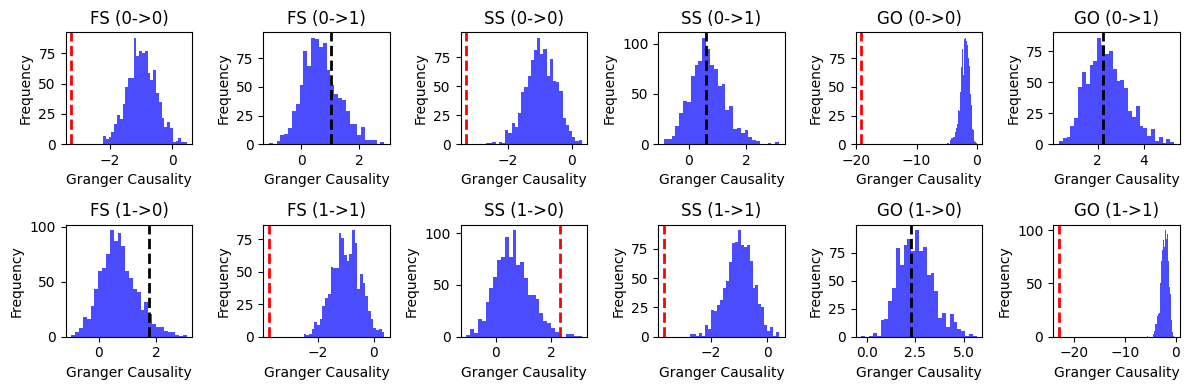

In [8]:
# Initialize dictionaries to store p-values and histograms
p_values = {cond: np.zeros((neurons, neurons)) for cond in conditions}

fig=plt.figure(figsize=(12,4)) 
gs = GridSpec(2, 6)

# Compute p-values for each matrix in each condition
for cond_idx, cond in enumerate(conditions):
    observed_gc_matrix = np.mean(signed_gc_matrices[cond], axis=0)  # Average across subjects
    permuted_gc_array = np.array(permuted_signed_gc_matrices[cond])  # Convert to numpy array (shape: n_permutations x neurons x neurons)
    
    for i in range(neurons):
        for j in range(neurons):
            ax = fig.add_subplot(gs[i,cond_idx*2+j])
            observed_value = observed_gc_matrix[i, j]
            null_distribution = permuted_gc_array[:, i, j]

            # Compute two-tailed p-value
            p_values[cond][i, j] = (np.sum(np.abs(null_distribution) >= np.abs(observed_value)) + 1) / (n_permutations + 1)

            # Plot histogram of null distribution with observed value
            plt.hist(null_distribution, bins=30, alpha=0.7, color='blue', label='Permuted GC')
            col='black'
            if p_values[cond][i, j]<0.05:
                col='red'
            plt.axvline(x=observed_value, color=col, linestyle='dashed', linewidth=2, label='Observed GC')
            plt.title(f"{cond} ({i}->{j})")
            plt.xlabel("Granger Causality")
            plt.ylabel("Frequency")
    plt.tight_layout()

# Print computed p-values for inspection
for cond, p_val_matrix in p_values.items():
    print(f"P-values for condition {cond}:")
    print(p_val_matrix)


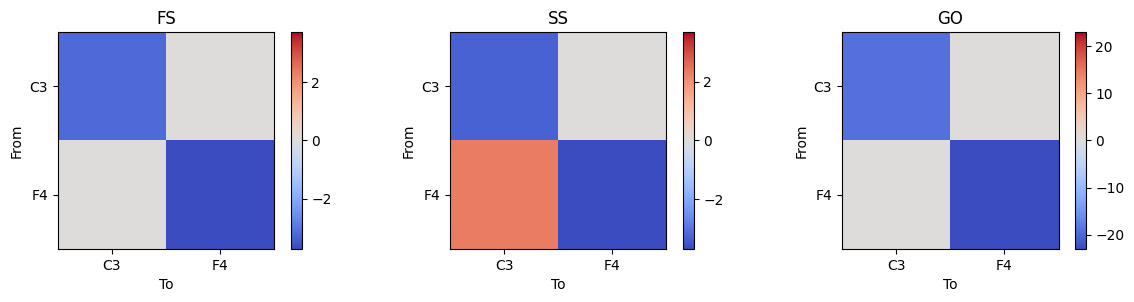

In [9]:
fig=plt.figure(figsize=(12,3))
gs = GridSpec(1, 3)
for cond_idx, cond in enumerate(signed_gc_matrices):
    ax = fig.add_subplot(gs[0,cond_idx])
    gc_mat=np.mean(np.array(signed_gc_matrices[cond]),axis=0)
    gc_mat[p_values[cond]>=0.05]=0
    maxabs=np.max(np.abs(gc_mat[:]))
    # Display results
    im=plt.imshow(gc_mat, cmap='coolwarm', interpolation='none', clim=[-maxabs, maxabs])
    plt.colorbar()
    plt.title(cond)
    plt.xlabel("To")
    plt.ylabel("From")
    plt.xticks([0,1])
    ax.set_xticklabels(['C3','F4'])
    plt.yticks([0,1])
    ax.set_yticklabels(['C3','F4'])
plt.tight_layout()